# Introduction
I had previously written a short kernel to practice Python. My "native language" is R, but the benefits of using Python are too great to ignore. In this notebook, I revist the same dataset but attempt several additional techniques, including: 
1. Pre-process with object-oriented programming
2. Create Pipeline
3. Use partial dependency plots
4. running multiple aglorithms through a pipeline

The individual elements could be the subject af a kernel all to themselves, but I am choosing to make each occupy a section within this Kernel. I hope this helps you on your python journey! 

# Import Libraries

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
from subprocess import check_output
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA, SparsePCA
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, Imputer, StandardScaler, PolynomialFeatures
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer, MissingIndicator 
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, IsolationForest
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import reciprocal, uniform
import functools
import shap

# Dictionaries

Below is a (nested?) dictionary which contains specific values for each column. This was initially performed by another user on Kaggle -- if someone happens to know who made these dicionaries initially then I will edit this notebook and provide proper attribution.  My contribution was to coalesce all of the user's individual dictionaries into one. 

In [3]:
replacement_dict = {"MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun", 7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"},
            "SaleCondition" : {"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1},
            "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
            "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
            "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, "Min2" : 6, "Min1" : 7, "Typ" : 8},
            "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
            "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
            "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
            "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
            "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
            "Street" : {"Grvl" : 1, "Pave" : 2},
            "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4},
            #"OverallQual" : {1 : 1, 2 : 1, 3 : 1, # bad
            #               4 : 2, 5 : 2, 6 : 2, # average
            #               7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
            #              },
            #"OverallCond" : {1 : 1, 2 : 1, 3 : 1, # bad
            #                          4 : 2, 5 : 2, 6 : 2, # average
            #                          7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
            #                         },
    #"ModExterCond" : {1 : 1, # bad
    #                                               2 : 1, 3 : 1, # average
    #                                               4 : 2, 5 : 2 # good
    #                                              },
    #"ModExterQual" : {1 : 1, # bad
    #                                               2 : 1, 3 : 1, # average
    #                                               4 : 2, 5 : 2 # good
    #                                              },
    #"ModFunctional" : {1 : 1, 2 : 1, # bad
    #                                                 3 : 2, 4 : 2, # major
    #                                                 5 : 3, 6 : 3, 7 : 3, # minor
    #                                                 8 : 4 # typical
    #                                                },
    #"ModKitchenQual" : {1 : 1, # bad
    #                                                   2 : 1, 3 : 1, # average
    #                                                   4 : 2, 5 : 2 # good
    #                                                  },
    #"ModHeatingQC" : {1 : 1, # bad
    #                                               2 : 1, 3 : 1, # average
    #                                               4 : 2, 5 : 2 # good
    #                                              }   
}

# Pre-process with Object Oriented Programming

I have learned that there are many benefits to using OOP with Python. It makes code more readable, reproducible, testable, etc. For this section, I create a python class specifically for this competition to handle the "pre-processing" of the data. What I mean by "pre-processing" is making the training and testing sets equivalent in form. This class contains functions to: 
1. Load the training and testing data
2. Generate a "submission" dataframe
3. Use the above dictionary to replace vlalues
4. Log transforming the response
5. Removing categories that do not show up in Test (to allow for one-hot-encoding)

In [4]:
# Define Class
class HousingPricesRegression():
    # class initialization
    def __init__(self, train_path, test_path):
        self.train = pd.read_csv(train_path)
        self.test = pd.read_csv(test_path)
        self.submission = pd.DataFrame()
        self.percent = 0.07
        self.keep_columns = []
        self.model_list={}
        self.reg_pipe = None
        self.rs_reg = None
        self.regres = None
        self.score = None
        
    def gen_submission_file(self, id_col):
        self.submission[id_col] = self.test[id_col]
        self.test.drop([id_col], axis = 1, inplace=True)
        self.train.drop([id_col], axis = 1, inplace=True)
        
    # replace information within columns
    def replace_values(self, replace_dict):
        # Find name (top level key)
        key_name = str(*replace_dict)
        true_index = np.where(self.train.columns.isin([key_name]))
        col_name = list(self.train.columns[true_index])
        if len(col_name) == 0:
            # Option 1: Dictionary refers to a key that doesn't exist. Create one!
            orig_name = key_name[3:]
            self.train[key_name] = self.train[orig_name].map(replace_dict[key_name])
            self.test[key_name] = self.test[orig_name].map(replace_dict[key_name])
        else:
            # Option 2: Dictionary refers to a key that does exist. Modify! 
            # Take 'ModExterCond' and find the original ("ExterCond")
            self.train[key_name] = self.train[key_name].map(replace_dict[key_name])
            self.test[key_name] = self.test[key_name].map(replace_dict[key_name])
            
    # Take Logarithm of Response
    def create_response(self, response):
        self.price_labels = np.log(self.train[response].copy() + 1)
        self.orig_resp = self.train[response]
        # drop original to avoid confusion
        self.train.drop([response], axis=1, inplace = True)  
        
    def drop_missing(self, threshold_percent):
        self.percent = ( self.train.isnull().sum() / self.train.isnull().count() ).sort_values(ascending=False)
        ## make list of columns to be dropped
        self.keep_columns = list(self.percent[self.percent < threshold_percent].index)
        ## drop columns
        self.train = self.train[self.keep_columns]
        self.test = self.test[self.keep_columns]
        
    # Remove categories 
    def remove_categories(self, cat_cols):
        for i in cat_cols:
            trn = self.train[i].astype('category')
            trn = trn.cat.categories
            tst = self.test[i].astype('category')
            tst = tst.cat.categories
            # Find that which is in test which is not in train
            unique_values_train = list(set(trn) - set(tst))
            # Check 
            # If no difference, print
            if len(unique_values_train)==0:
                print("No Differnence for {}".format(i))
            else:
                # If there is a differnce, change to NA in test for later imputation
                for j in unique_values_train:
                    to_replace_index = self.train.loc[self.train[i]==j,i].index
                    self.train.loc[to_replace_index,i] = float('NaN')
                    self.train[i] = self.train[i].cat.remove_categories(j)
                    print("{} removed from {} in train".format(j,i))
                    
    # Set the category type 
    def make_category(self, cat_cols):
        self.train[cat_cols] = self.train[cat_cols].astype('category')
        self.test[cat_cols] = self.test[cat_cols].astype('category')
    
    # Run the pipe
    def run_pipeline(self, pipe, names, regressors, parameters, X_train, X_val, y_train, y_val):
        self.model_list = {}
        for name, regressor, params in zip(names, regressors, parameters):
            self.reg_pipe = Pipeline([
                ('pipeline', pipe),
                ('reg', regressor)
            ])
            self.rs_reg = RandomizedSearchCV(self.reg_pipe, params, n_iter=10, verbose=2, random_state=42, scoring='neg_mean_squared_error')
            self.regres = self.rs_reg.fit(X_train, y_train)
            self.score = self.regres.score(X_val, y_val)
            print("{} score: {}".format(name, self.score))
            self.model_list[name] = self.regres

### Load Data

In [5]:
# Define Paths
file_path = ''
train_path = str(file_path) + str('train.csv')
test_path = str(file_path) + str('test.csv')
submission_path = str(file_path) + str()

# Instantiate model object
hprObject = HousingPricesRegression(train_path, test_path)

# Generate submission file
hprObject.gen_submission_file(id_col='Id')

### Create Response
This creates a single column dataframe called `price_labels` that is a copy of that in train, except log-transformed. The corresponding column in the train dataframe is also dropped. The graph below shows how the data becomes centered after the logarithmic transformation.

In [6]:
# This takes the log of the sales price
hprObject.create_response(response="SalePrice")

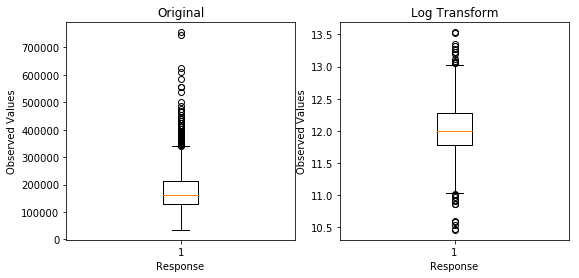

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,4))
axes[0].boxplot(hprObject.orig_resp)
axes[0].set_title('Original')
axes[1].boxplot(hprObject.price_labels)
axes[1].set_title('Log Transform')

for ax in axes:
    ax.set_xlabel('Response')
    ax.set_ylabel('Observed Values')
plt.show()

### Call Replacement Method
Loop through the dictionary replacing the values listed therein for each column.

In [8]:
# Replace features - multiple columns
for key, values in replacement_dict.items():
    temp_dict = {}
    temp_dict[key] = replacement_dict[key] 
    hprObject.replace_values(temp_dict)

### Drop Missing
All columns missing more than "threshold percent" are dropped. Also shown is a custom transformer to accomplish this.

In [9]:
## Custom transformer not used...
# class DropMissing(BaseEstimator, TransformerMixin):
#    def __init__(self, threshold_percent):
#        self.keep_columns = None
#        self.threshold_percent = threshold_percent
#    def fit(self, X, y=None):
#        return self
#    def transform(self, X):
#        ## calculate percent missing
#        percent = ( X.isnull().sum() / X.isnull().count() ).sort_values(ascending=False)
#        ## make list of columns to be dropped
#        self.keep_columns = list(percent[percent < self.threshold_percent].index)
#        X = X[self.keep_columns]
#        return X
#    def fit_transform(self, X, y=None):
#        return self.fit(X,y).transform(X)

## Drop colums which have too many missing rows
hprObject.drop_missing(threshold_percent=0.06)

### Set Category and Numeric Columns

In [10]:
## Create list of numerical and categorical attributes
num_cols = hprObject.test._get_numeric_data().columns
cat_cols = list(set(hprObject.test.columns) - set(num_cols))
num_cols = list(num_cols)

## Need to move this to a class method or something
hprObject.make_category(cat_cols)

In [11]:
#hprObject.train[num_cols] = hprObject.train[num_cols].apply(pd.to_numeric)

### Identify outliers with Isolation Forest

In [12]:
## Create an arbitrary split
#X_iso_train, X_iso_val, y_iso_train, y_iso_val = train_test_split(hprObject.train, hprObject.price_labels, test_size = 0.2, random_state=24)

## cross-validate pipeline (may need to impute missing as zero)
num_imputer = ColumnTransformer(
    transformers = [
        ('num_imp', SimpleImputer(strategy='constant',fill_value=0.0, copy=False), num_cols)
    ],
    remainder='drop'
)

cat_imputer = ColumnTransformer(
    transformers = [
        ('cat_imp', SimpleImputer(strategy='most_frequent', copy=False), cat_cols)
    ],
    remainder='drop'
)

step1 = Pipeline([
    ('nums', num_imputer)
])

step2 = Pipeline([
    ('categ', cat_imputer),
    ('encode', OneHotEncoder(handle_unknown='ignore'))
])

step3 = FeatureUnion([
    ('numeric_stuff', step1 ),
    ('category_stuff', step2)
])

iso_pipeline = Pipeline([
    ('final', step3),
    ('fit', IsolationForest(n_estimators=15,
                            contamination=0.15,
                            behaviour='new'))
])

iso_fit = iso_pipeline.fit(X=hprObject.train, y=hprObject.price_labels)

In [13]:
outlier_flag = iso_fit.predict(X=hprObject.train)

In [14]:
hprObject.train['OutlierFlag'] = outlier_flag

In [58]:
outlier_df = hprObject.train[hprObject.train.loc[:,'OutlierFlag']==-1]
outlier_df.head()

,GarageCond,GarageType,GarageYrBlt,GarageFinish,GarageQual,BsmtExposure,BsmtFinType2,BsmtFinType1,BsmtCond,BsmtQual,...,GrLivArea,LowQualFinSF,2ndFlrSF,1stFlrSF,CentralAir,SaleType,Heating,TotalBsmtSF,MSSubClass,OutlierFlag
8,TA,Detchd,1931.0,Unf,Fa,No,Unf,Unf,TA,TA,...,1774,0,752,1022,Y,WD,GasA,952,50,-1
9,TA,Attchd,1939.0,RFn,Gd,No,Unf,GLQ,TA,TA,...,1077,0,0,1077,Y,WD,GasA,991,190,-1
11,TA,BuiltIn,2005.0,Fin,TA,No,Unf,GLQ,TA,Ex,...,2324,0,1142,1182,Y,New,GasA,1175,60,-1
29,TA,Detchd,1920.0,Unf,Fa,No,Unf,Unf,TA,TA,...,520,0,0,520,N,WD,GasA,520,30,-1
30,Fa,Detchd,1920.0,Unf,TA,No,Unf,Unf,TA,TA,...,1317,0,668,649,N,WD,GasA,649,70,-1


## Explore Outliers

In [52]:
# Define Plotting method
def plot_outliers1(col='OverallQual'):
    y_out = hprObject.orig_resp[hprObject.train.loc[:,'OutlierFlag']==-1]
    y_n = hprObject.orig_resp[hprObject.train.loc[:,'OutlierFlag']==1]
    x_out = hprObject.train[hprObject.train.loc[:,'OutlierFlag']==-1][col]
    x_n = hprObject.train[hprObject.train.loc[:,'OutlierFlag']==1][col]
    
    fig, axes = plt.subplots(figsize=(9,4))
    axes.scatter(x_n, y_n, c='blue', alpha=0.3)
    axes.scatter(x_out, y_out, c='red', alpha=0.3)
    axes.set_xlabel(col)
    axes.set_ylabel('Sales Price')
        
    plt.show()

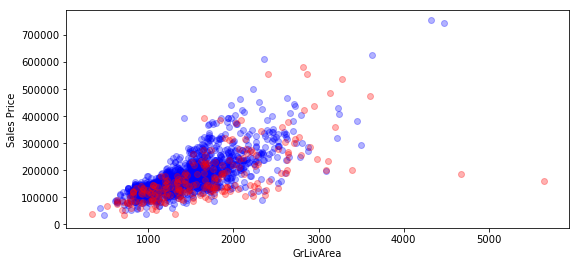

In [51]:
plot_outliers1(col='GrLivArea')

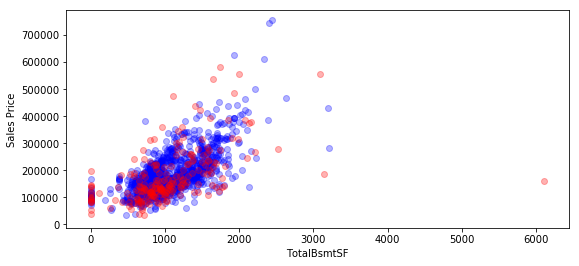

In [53]:
plot_outliers1(col='TotalBsmtSF')

# Pipeline

### Pipelines Finally
And now we are finally able to create a pipeline. There are so many powerful scripts / notebooks on Kaggle, and yet so few examples as to how to use the pipeline library. I now going to put the HousingRegressionPrices class aside and focus on building a pipeline. I found this process quite challenging because I am quite new to python. I am pleased with the result and I encourage you to take it and make it even better! 

The key to underatanding this pipeline is that not all columns go through the pipeline "equally". There are essentially three groups of columns: 

1. Numeric columns which are used to create new features
2. Numeric columns which are not used to create new features
3. Categorical columns which are one-hot-encoded

These 3 groups of columns are bound back together horizontally by "Feature Union". 

#### Group 1: Numeric Columns & Feature Creation
In the first edition of [*Hands-On Machine Learning with Scikit-Learn and TensorFlow*](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow-ebook/dp/B06XNKV5TS/ref=sr_1_4?crid=1D12AT1KWITI1&keywords=hands+on+machine+learning+with+scikit-learn+and+tensorflow&qid=1555695123&s=gateway&sprefix=hands+on+machine+lear%2Caps%2C156&sr=8-4), Aurelien Geron explained how to create custom transformers which work with pandas dataframes. Recently, however, a new class has been introduced in Sklearn called [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) which effectively does this for you. I feed in speciifc columns *by name* and have PolynomialFeatures create interactions between these features. If you do not set 'remainder' to 'drop' then the other columns will be passed through this transformer in addition to the columns you explicitly speciifed. This could be confusing later, so I definitely advocate the use of 'drop'. Imputation and StandardScaleing is also performed. See 'step1' for the pipeline. 

#### Group 2: Other Numeric Columns
Since I've elected to 'drop' the non-named numeric columns, I need to gerate another set of transformers which works on them. See 'step2' for the pipeline. I also create a missing indicator matrix so that my modeling method can specifically learn which values were imputed. 

#### Group 3: Categorical
I have the categorical data go through its own series of steps, first imputing by "most_frequent" and then converting the data into a one-hot-encoding. Again I create amissing indicator matrix so that imputed values can be learned. 

And here is the pipeline in all its glory. 

In [14]:
## Column Names ##
# These were troublesome
# kitchen_col = ['KitchenAbvGr', 'KitchenQual']
# add_area = ['GrLivArea','TotalBsmtSF']
# count_bath = ['BsmtFullBath','FullBath','BsmtHalfBath','HalfBath']
# Using these:
grade_col = ['OverallQual', 'OverallCond']
exter_cond = ['ExterQual','ExterCond']
add_floor = ['1stFlrSF', '2ndFlrSF']
add_porch = ['OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch']

#origFeat = grade_col + exter_cond + add_floor + add_porch 

feat_eng_names = grade_col + ['OverallTotal'] + exter_cond + ['ExterTotal'] + \
add_floor + ['FlrSFTotal'] + add_porch + ['UnionPorch'] + ['ModPorch1'] + ['ModPorch2'] + ['ModPorch3'] + ['ModPorch4'] + ['ModPorch5'] 

other_num_cols = list(set(num_cols) - set(feat_eng_names))

## Actually, move the problem children 'multi_kitchen', 'add_total_SF', 'count_baths' to the 'other numeric' group. 
## They will be imputed with all the others, and feature engineering will be performed on the data without NAs
## And that should be perfect! 

## Step 1: Feature Engineering ##
feature_engineering = ColumnTransformer(
    transformers = [
        ('multi_grade', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False), grade_col),
        ('multi_exter', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False), exter_cond),
        ('add_floor_SF', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False), add_floor),
        ('add_porch_SF', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False), add_porch),
    ],
    remainder='drop'
)

step1 = Pipeline([
    ('feat_eng', feature_engineering),
    ('impute_feats', SimpleImputer(strategy="mean", copy=False)),
 #   ('scale_feats', StandardScaler())
])

## Step 2: Other Numeric Columns ##
other_numerical = ColumnTransformer(
    transformers = [
        ('impute_other', SimpleImputer(strategy="mean", copy=False), other_num_cols),
    ],
    remainder='drop'
)

step2 = Pipeline([
    ('other_nums', other_numerical),
#    ('scale_other', StandardScaler())
])

## Step 3: Categorical Columns ## 
categorical = ColumnTransformer(
    transformers = [
        ('impute_cats', SimpleImputer(strategy="most_frequent", copy=False), cat_cols),
    ],
    remainder='drop'
)

step3 = Pipeline([
    ('categ', categorical),
    ('encode', OneHotEncoder(handle_unknown='ignore'))
])

## Step 4: Missing indicators 
other_missing = ColumnTransformer(
    transformers = [
        ('other_missing', MissingIndicator(features='all'), other_num_cols)
    ],
    remainder='drop'
)

category_missing = ColumnTransformer(
    transformers = [
        ('cat_missing', MissingIndicator(features='all'), cat_cols)
    ],
    remainder='drop'
)

## Step 5: Unify ##     
unify = FeatureUnion([
    ('new_features', step1 ),
    ('numeric_scale', step2), 
    ('categoric_encode', step3),
#    ('num_missing_indicator', other_missing),
#    ('cat_missing_indicator', category_missing)
])

final_pipeline = Pipeline([
    ('finally', unify)
])

## Just checking
#f = final_pipeline.fit_transform(hprObject.train)
#type(f)

# Model Parameters

The "prepared" data is now split (simply) into training / validation sets. The dataset for this competition is very small, so I was hesitant to make the test set much larger. 
I also specify a few parameters for both SVR() and RandomForestRegressor(). You'll see why the nested diciontary is necessary in a moment. 

In [15]:
# split train into train and validation set
X_train, X_val, y_train, y_val = train_test_split(hprObject.train, hprObject.price_labels, test_size = 0.2)

# list names of regressors
names = [
         "Support-Vector Regressor",
         "Random Forest Regressor"
        ]

regressors = [
    SVR(),
    RandomForestRegressor()
]

parameters = [
                  {
                      'reg__C': (reciprocal(0.001, 0.1)), 
                      'reg__gamma': (uniform(1, 10))
                  },
                  {
                      'reg__max_depth': (5,10,15)
                  }
             ]

## Model
I wanted to have the ability to run multiple models on the same pipeline. Someone (I forget the link) posted some code on StackOverFlow; I've adapted it here. Essentially, a pipeline is appended within a for-loop with different regressors. The pipeline is fit with the training data, scored, and the model is saved in the 'model_list' dictionary for future use. I also use RandomizedGridSearch instead of ordinary GridSearch because...I'm cool :) .

In [16]:
# Pass pipeline, names, regressors, parameters, and training/validation data
# basically it's a wrapper for pipeline.fit()
hprObject.run_pipeline(pipe=final_pipeline,
                       names=names, 
                       regressors=regressors, 
                       parameters=parameters, 
                       X_train=X_train,
                       X_val=X_val,
                       y_train=y_train,
                       y_val=y_val)


/home/gopherguy14/anaconda3/envs/kaggle_comps/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] reg__C=0.005611516415334503, reg__gamma=10.50714306409916 .......
[CV]  reg__C=0.005611516415334503, reg__gamma=10.50714306409916, total=   0.3s
[CV] reg__C=0.005611516415334503, reg__gamma=10.50714306409916 .......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  reg__C=0.005611516415334503, reg__gamma=10.50714306409916, total=   0.3s
[CV] reg__C=0.005611516415334503, reg__gamma=10.50714306409916 .......
[CV]  reg__C=0.005611516415334503, reg__gamma=10.50714306409916, total=   0.3s
[CV] reg__C=0.029106359131330688, reg__gamma=6.986584841970366 .......
[CV]  reg__C=0.029106359131330688, reg__gamma=6.986584841970366, total=   0.3s
[CV] reg__C=0.029106359131330688, reg__gamma=6.986584841970366 .......
[CV]  reg__C=0.029106359131330688, reg__gamma=6.986584841970366, total=   0.3s
[CV] reg__C=0.029106359131330688, reg__gamma=6.986584841970366 .......
[CV]  reg__C=0.029106359131330688, reg__gamma=6.986584841970366, total=   0.3s
[CV] reg__C=0.0020513382630874496, reg__gamma=2.5599452033620267 .....
[CV]  reg__C=0.0020513382630874496, reg__gamma=2.5599452033620267, total=   0.3s
[CV] reg__C=0.0020513382630874496, reg__gamma=2.5599452033620267 .....
[CV]  reg__C=0.0020513382630874496, reg__gamma=2.5599452033620267, total=   0.3s
[CV] reg__C=0.002

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    8.0s finished


Support-Vector Regressor score: -0.16478801919055164
Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] reg__max_depth=5 ................................................


/home/gopherguy14/anaconda3/envs/kaggle_comps/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/gopherguy14/anaconda3/envs/kaggle_comps/lib/python3.6/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/gopherguy14/anaconda3/envs/kaggle_comps/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................................. reg__max_depth=5, total=   0.2s
[CV] reg__max_depth=5 ................................................
[CV] ................................. reg__max_depth=5, total=   0.2s
[CV] reg__max_depth=5 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
/home/gopherguy14/anaconda3/envs/kaggle_comps/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/gopherguy14/anaconda3/envs/kaggle_comps/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/gopherguy14/anaconda3/envs/kaggle_comps/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................................. reg__max_depth=5, total=   0.2s
[CV] reg__max_depth=10 ...............................................
[CV] ................................ reg__max_depth=10, total=   0.4s
[CV] reg__max_depth=10 ...............................................


/home/gopherguy14/anaconda3/envs/kaggle_comps/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................................ reg__max_depth=10, total=   0.4s
[CV] reg__max_depth=10 ...............................................


/home/gopherguy14/anaconda3/envs/kaggle_comps/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................................ reg__max_depth=10, total=   0.4s
[CV] reg__max_depth=15 ...............................................


/home/gopherguy14/anaconda3/envs/kaggle_comps/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................................ reg__max_depth=15, total=   0.5s
[CV] reg__max_depth=15 ...............................................


/home/gopherguy14/anaconda3/envs/kaggle_comps/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................................ reg__max_depth=15, total=   0.5s
[CV] reg__max_depth=15 ...............................................


/home/gopherguy14/anaconda3/envs/kaggle_comps/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................................ reg__max_depth=15, total=   0.5s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    3.3s finished
/home/gopherguy14/anaconda3/envs/kaggle_comps/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest Regressor score: -0.022255401441930875



#### Best SVR Parameters

In [17]:
hprObject.model_list['Support-Vector Regressor'].best_params_

{'reg__C': 0.004059611610484304, 'reg__gamma': 6.247564316322379}

#### Best RF Parameters

In [18]:
hprObject.model_list['Random Forest Regressor'].best_params_

{'reg__max_depth': 15}

# Shapley values from the SHAP module

Previously, I had used feature importance / partial dependency plots to evaluate some of my features. But I have found a better method: shapely values. Shapley values fullfill four critereia that are critical for explainability: 

1. Efficiency
2. Symmetry
3. Dummy
4. Additivity

Shapely values explains the average contribution of a feature to the prediction over a variety of different cohorts (subsets) of features.  
The shap module (which stands for SHapley Additive exPlanations) speeds up the process of calculating shapley values by performing some interpolation. 

Useful tips: 

1. Navigate your pipeline using 'named_steps['name'].transformer_list. I was able to find the one-hot-encoded names this way
2. shap can handle dataframes
3. Scipy.sparse_matrix can be converted to a dense array by .toarray()

### Generate Names

In [19]:
## Transform the Validation Set
X_train_prepared = final_pipeline.fit_transform(X_train)
y_train_values = y_train.values

## ELI5 requires dense matrix
X_val_prepared = final_pipeline.transform(X_val)
X_val_prepared = X_val_prepared.toarray()
y_val_values = y_val.values

ohe_names = hprObject.reg_pipe.named_steps['pipeline'].named_steps['finally'].transformer_list[2][1].named_steps['encode'].get_feature_names().tolist()
num_missing_names = [ i + str('_missing') for i in other_num_cols ]
cat_missing_names = cat_cols
#data_names = feat_eng_names + other_num_cols + ohe_names + num_missing_names + cat_missing_names
data_names = feat_eng_names + other_num_cols + ohe_names

### Create Dataframe

In [20]:
## Convert this into a pandas dataframe
X_val_df = pd.DataFrame(data=X_val_prepared, columns=data_names, index=[i for i in range(0, 292)])

### Fit Estimator Outside of Pipeline

In [21]:
## Interestingly, SVR() doesn't seem to work very well. Perhaps I need to perform dimension reduction
## on the training set
#svr_model = SVR(gamma = model_list['Support-Vector Regressor'].best_params_["reg__gamma"], 
#    C = model_list['Support-Vector Regressor'].best_params_["reg__C"]).fit(X_train_prepared, y_train_values)

rf_model = RandomForestRegressor(max_depth = hprObject.model_list['Random Forest Regressor'].best_params_["reg__max_depth"]).fit(X_train_prepared, y_train_values)


/home/gopherguy14/anaconda3/envs/kaggle_comps/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## Calculate Shapley Values

In [22]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_val_df)

The figure below is a summary of the shapely values for the top features learned by our model. 'OverallQual' has the highest, _average_ contribution to the predicted sales price. 'GrLivArea' is 2nd, with more of a continuous distribution. In general, it looks like 'low' values of features contribute to lower values of the response and 'high' values of features contribute to higher values of the response. There are some exceptions, like 'x24_Unf' for instance. 

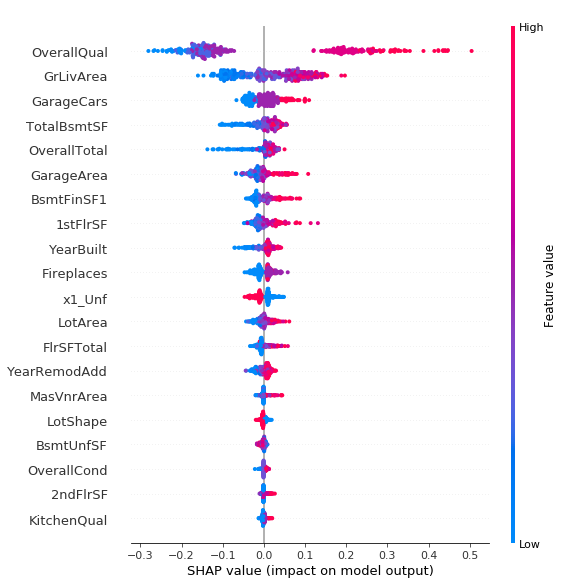

In [23]:
shap.summary_plot(shap_values, X_val_df)

It is possible to examine the interaction between two features. Here, we look at 'GrLivArea' and 'OverallQual'. The values of 'GrLivArea' are along the x-axis and the values of 'OverallQual' are plotted as colors. This graph shows us that there is a linear relationship bewteen GrLivArea and the sales price of the home. It looks like there is an interaction between the overal quality of the home nad the ground living area of the home.

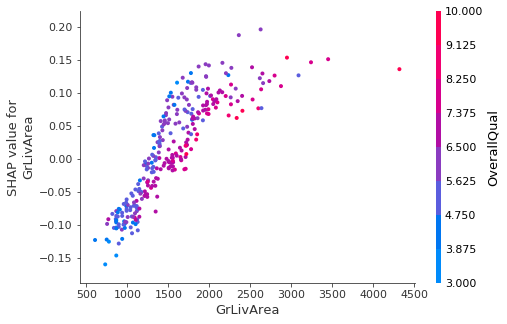

In [24]:
shap.dependence_plot("GrLivArea", shap_values, X_val_df)

Anything built before 1960 will decrease the sale price. There seems to be a large number of 1700-1900 sqf homes sold which were built from the 90s to present.  

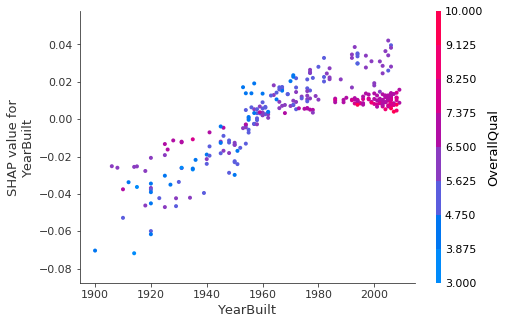

In [25]:
shap.dependence_plot("YearBuilt", shap_values, X_val_df)

# Final Fit
I am choosing to use the Random Forest model because its final score in my cross-validation scheme was much lower than than the SVM (-0.019 vs -0.148). Granted, I did not tune my hyperparameters *very well* and there are definitely more hyperparameters to choose from. I also think that I may need to perform some dimension reduction or eliminate the "missing indicators" for the SVM; when I tried to generate predictions from the SVM all that it predicted was the same value over and over. 

In [26]:
# Last pipe - using "tuned" hyperparameters for Random Forest (yes, much more tuning could be done!)
alldata_pipe = Pipeline([
        ('pipeline', final_pipeline),
        ('select', VarianceThreshold(0.15)),
        ('rf', RandomForestRegressor(
            max_depth=hprObject.model_list['Random Forest Regressor'].best_params_["reg__max_depth"]
        ))
        #('svm', SVR(
        #    gamma=model_list['Support-Vector Regressor'].best_params_['reg__gamma'],
        #    C=model_list['Support-Vector Regressor'].best_params_['reg__C']
        #))
    ])

# The final estimator, RandomForestRegressor(), does not have a .fit_transform method
final_model = alldata_pipe.fit(hprObject.train, hprObject.price_labels.values)

# And ta da! We have our predictions
log_predictions = final_model.predict(hprObject.test)

/home/gopherguy14/anaconda3/envs/kaggle_comps/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## Generate Submission File

Here I convert back from log+1 dollars back to regular dollars. 

In [27]:
predictions = (np.exp(log_predictions) - 1)
predictions

array([129355.97677063, 154810.66473283, 165453.26741343, ...,
       151527.90263787, 113384.78316444, 232803.64079923])

Submission Complete! 

In [28]:
hprObject.submission['SalePrice'] = pd.Series(predictions, index=hprObject.submission.index)
hprObject.submission.to_csv('submission29May2019.csv',index=False)